In [ ]:
import numpy as np
import pandas as pd
import csv
import pickle
import os
import gc
import scipy
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix,accuracy_score
import seaborn as sns
from keras.utils import np_utils
from keras.layers import LSTM, BatchNormalization,Reshape
import tensorflow
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# enable gpu
from keras import backend as K
K._get_available_gpus()

['/device:GPU:0']

In [ ]:
DataPath=  '/content/drive/MyDrive/Colab Notebooks/pattern/lab4/data/RML2016.10b.dat' #'/content/drive/MyDrive/ModulationClassification/RML2016.10b.dat'

In [ ]:
pickle_in = open(DataPath,"rb")
data = pickle.load(pickle_in, encoding="bytes")

In [ ]:
def load_data(data):
  s = np.empty((0,128,2))
  l=np.array([])
  for key in data.keys():
    # load samples
    x,y=key
    x = x.decode('ascii')
    samples = np.array(data.get(key)).transpose(0, 2, 1)
    # create labels
    labels = np.repeat(x+'_'+str(y),samples.shape[0])
    l=np.concatenate([l,labels])
    s=np.vstack((s,samples))
    print('key',key)
    print("samples:",samples.shape)
    print('labels',labels.shape)
  return l,s,data.keys()
  

In [ ]:
def split_tuple(labels):
  label, snr = map(list, zip(*(x.split('_') for x in labels)))
  label,snr=np.array(label),np.array(snr)
  return label,snr

In [ ]:
def first_drev(data):
  drev = np.empty((0,128,2))
  for i in range(200):
    print(i)
    tmp = np.gradient(data[i*6000:i*6000+6000][:][:],axis=1)
    drev=np.vstack((drev,tmp))
    del tmp
  return drev


In [ ]:
def integral(data):
  data=np.pad(data, [(0, 0),(0,0),(0,1)], 'constant')
  integral = np.empty((0,128,2))
  for i in range(200):
    print(i)
    tmp = scipy.integrate.cumtrapz(data[i*6000:i*6000+6000][:][:],dx=1)
    integral=np.vstack((integral,tmp))
    del tmp
  return integral

In [ ]:
def create_model():
  number_of_channels = 4 
  model = Sequential()
  
  model.add(Conv2D(64, (1,3),padding='same',input_shape=(128, number_of_channels,1), activation='relu'))

  model.add(Conv2D(16, (2,3),padding='same',activation='relu'))

  model.add(BatchNormalization())
  
  model.add(Flatten())
  model.add(Reshape((-1, 16)))
  model.add(LSTM(64))

  model.add(BatchNormalization())

  model.add(Dense(10, activation ='softmax'))


  

  return model

In [ ]:
# get samples and labels
labels, samples,classes = load_data(data)

In [ ]:
# test drevative
d = np.array(first_drev(samples))
print("drevative:",d.shape)



In [ ]:
# test integration
i = np.array(integral(samples))
print("integral:",i.shape)

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/pattern/lab4/drev_raw.npy'
samples = np.load(path)
path = '/content/drive/MyDrive/Colab Notebooks/pattern/lab4/labels.npy'
labels= np.load(path)

In [ ]:
# to encode the labels
lb = LabelEncoder()

# split data into train and test
x_train, x_test, y_train, y_test = train_test_split(samples, labels,test_size=0.3, random_state=1 ,stratify=labels)
del samples
del labels
gc.collect()
# take 5% of training set for validation 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,test_size=0.05, random_state=1,stratify=y_train)

y_train,snr_train = split_tuple(y_train)
y_test,snr_test = split_tuple(y_test)
y_val,snr_val=split_tuple(y_val)

# encode labels
y_train_lb = np_utils.to_categorical(lb.fit_transform(y_train))
y_val_lb = np_utils.to_categorical(lb.fit_transform(y_val))
del y_train
del y_val
gc.collect()

0

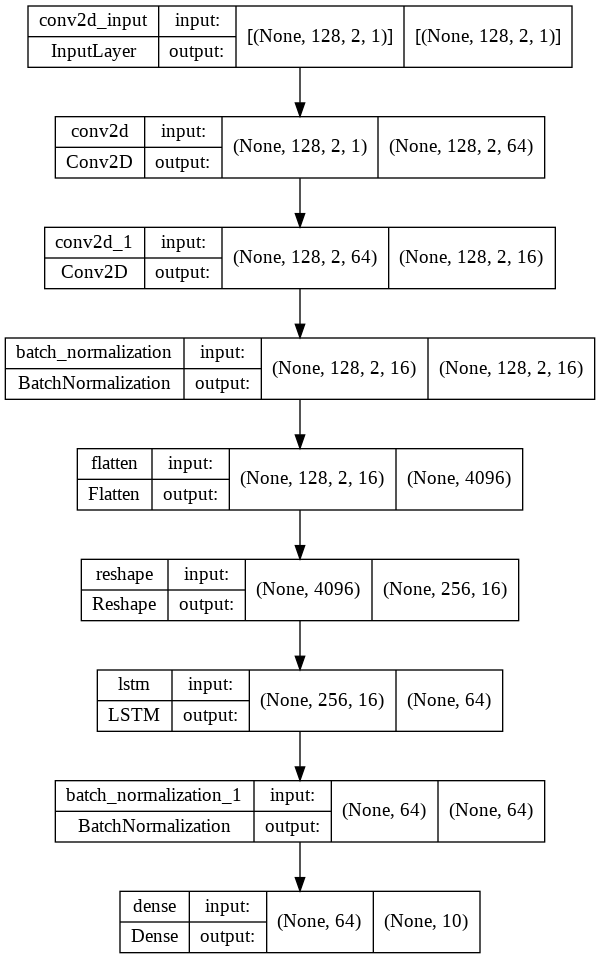

In [ ]:
# create model
model = create_model()
model.compile(loss = 'categorical_crossentropy',optimizer = 'Adam', metrics = ['accuracy'])
# Save an image of the model's architecture to a file
plot_model(model, to_file='Feed Forward NN.png', show_shapes=True, show_layer_names=True)

In [ ]:
rates = [1e-4]
epochs = 50
path = '/content/drive/MyDrive/Colab Notebooks/pattern/lab4/data/combined/drev/bonus/'
checkpoint_filepath = path+'checkpoint_cnn'
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
for lr in rates:
  print("Learning rate:",lr)
  gc.collect()
  model = create_model()
  callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
  opt = tensorflow.keras.optimizers.Adam(learning_rate=lr)
  model.compile(loss = 'categorical_crossentropy',optimizer = opt, metrics = ['accuracy'])

  # train model
  cnn_results = model.fit(x_train, y_train_lb,
                  epochs = epochs,
                  verbose = 1,
                  validation_data = (x_val, y_val_lb),callbacks=[callback,model_checkpoint_callback])
  # Plot model accuracy over ephocs
  plt.plot(cnn_results.history['accuracy'])
  plt.plot(cnn_results.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig(path+f'lr_{str(lr)}.png')
  plt.show()
  gc.collect()
  print("**************************************************\n\n")


Epoch 1/10
24938/24938 [==============================] - 531s 21ms/step - loss: 0.9848 - accuracy: 0.6038 - val_loss: 1.0098 - val_accuracy: 0.5897
Epoch 2/10
24938/24938 [==============================] - 524s 21ms/step - loss: 0.9803 - accuracy: 0.6059 - val_loss: 1.0074 - val_accuracy: 0.5925
Epoch 3/10
24938/24938 [==============================] - 521s 21ms/step - loss: 0.9759 - accuracy: 0.6073 - val_loss: 1.0061 - val_accuracy: 0.5975
Epoch 4/10
24938/24938 [==============================] - 523s 21ms/step - loss: 0.9720 - accuracy: 0.6097 - val_loss: 0.9929 - val_accuracy: 0.6019
Epoch 5/10
24938/24938 [==============================] - 512s 21ms/step - loss: 0.9677 - accuracy: 0.6110 - val_loss: 0.9711 - val_accuracy: 0.6072
Epoch 6/10
24938/24938 [==============================] - 502s 20ms/step - loss: 0.9631 - accuracy: 0.6132 - val_loss: 0.9750 - val_accuracy: 0.6078
Epoch 7/10
24938/24938 [==============================] - 506s 20ms/step - loss: 0.9591 - accuracy: 0.6153

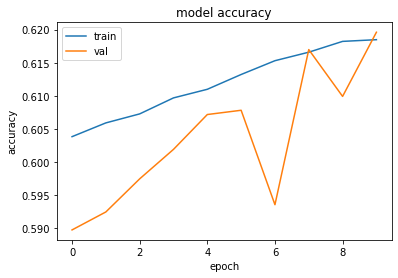

7712

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/pattern/lab4/backup/bonus_drev/'
checkpoint_filepath = path+'check_bonus_drev22'
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
model = create_model()
opt = tensorflow.keras.optimizers.Adam(learning_rate=1e-4)
model.load_weights(checkpoint_filepath)
model.compile(loss = 'categorical_crossentropy',optimizer = opt, metrics = ['accuracy'])

# train model
cnn_results = model.fit(x_train, y_train_lb,
                  epochs = 10,
                  verbose = 1,
                  validation_data = (x_val, y_val_lb),callbacks=[model_checkpoint_callback])
# Plot model accuracy over ephocs
plt.plot(cnn_results.history['accuracy'])
plt.plot(cnn_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
gc.collect()

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/pattern/lab4/data/drev_bonus.h5')

In [ ]:
# train accuracy
score = model.evaluate(x_train, y_train_lb, verbose=0)
print("Training Accuracy: ", score[1])

Training Accuracy:  0.09997870028018951


In [ ]:
del x_train
del y_train_lb
del x_val
del y_val_lb
gc.collect()

1003

In [ ]:
# evaluate test set
# encode labels
y_test_lb = np_utils.to_categorical(lb.fit_transform(y_test))

score = model.evaluate(x_test, y_test_lb, verbose=0)
print("Testing Accuracy: ", score[1])

Testing Accuracy:  0.6184083223342896


In [ ]:
# to get confusion matrix
y_test_classes = y_test_lb.argmax(1)
y_predicted = model.predict(x_test)
y_pred_classes = np.argmax(y_predicted,axis=1)


In [ ]:
classes = np.load('/content/drive/MyDrive/Colab Notebooks/pattern/lab4/classes.npy')

In [ ]:
# get confusion matrix
confusion_matrix1 = confusion_matrix(y_true= y_test_classes, y_pred=y_pred_classes)
classes = np.array([x[0] for x in classes])
classes=np.unique(classes)
print(classes)
#Add labels to confusion matrix
confusion_matrix1 = pd.DataFrame(confusion_matrix1, columns=list(classes), index=list(classes))

print("The rows represents the true values or observations")
print("The columns respresent the model's predictions")

#Print confusion matrix results
confusion_matrix1

[b'8PSK' b'AM-DSB' b'BPSK' b'CPFSK' b'GFSK' b'PAM4' b'QAM16' b'QAM64'
 b'QPSK' b'WBFM']
The rows represents the true values or observations
The columns respresent the model's predictions


,b'8PSK',b'AM-DSB',b'BPSK',b'CPFSK',b'GFSK',b'PAM4',b'QAM16',b'QAM64',b'QPSK',b'WBFM'
b'8PSK',24869,879,1790,2643,2732,200,281,328,1429,849
b'AM-DSB',2590,26147,886,825,2065,105,10,2,250,3120
b'BPSK',4699,933,23401,1732,2492,763,118,144,881,837
b'CPFSK',4432,898,1472,24114,3278,180,90,65,632,839
b'GFSK',3250,1167,1101,1722,26344,124,27,15,409,1841
b'PAM4',3157,672,3201,1323,1832,24196,140,316,523,640
b'QAM16',5071,491,1256,2038,1714,200,19755,3906,1053,516
b'QAM64',3642,340,866,1601,1176,179,3748,23188,930,330
b'QPSK',6779,821,1798,2602,2734,204,305,316,19662,779
b'WBFM',2626,17299,868,899,2983,67,19,4,284,10951


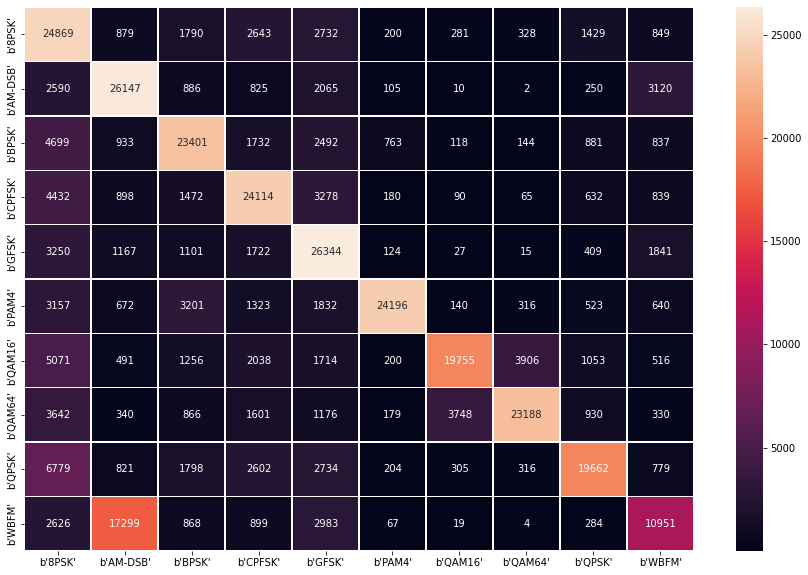

In [ ]:
# get most confusing classes
fig, ax = plt.subplots(figsize=(15,10))         # Sample figsize in inches
sns.heatmap(confusion_matrix1, annot=True, linewidths=.5, ax=ax, fmt='g')

In [ ]:
# Print f1, precision, and recall scores
print("Percision: ",precision_score(y_test_classes, y_pred_classes , average="macro"))
print("Recall: ",recall_score(y_test_classes, y_pred_classes , average="macro"))
print("F-score: ",f1_score(y_test_classes, y_pred_classes , average="macro"))

Percision:  0.6572071458575122
Recall:  0.6184083333333333
F-score:  0.6210280509288391


In [ ]:
# group by snr
snr_test = [int(snr) for snr in snr_test]
sorted_snrs = np.sort(np.unique(snr_test))
x = []
y = []
for snr in sorted_snrs:
  idx = np.where(snr_test == snr)
  x.append(snr)
  y.append(accuracy_score(np.argmax(y_test_lb[idx], axis = 1), np.argmax(y_predicted[idx], axis = 1)))


In [ ]:
# print results of snr
pd.DataFrame(data = np.array(y).reshape(1, -1) * 100,  columns = sorted_snrs, index = ['accuracy']).round(2)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.81,10.93,12.5,13.99,19.16,26.87,35.24,50.87,66.75,79.36,86.61,89.98,90.92,91.77,91.64,91.96,91.66,91.86,92.03,91.92


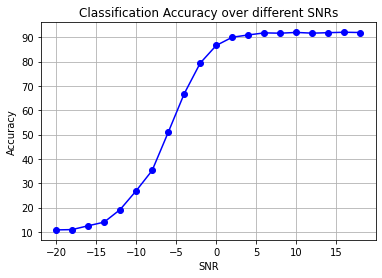

In [ ]:
# plot accuracy vs snr
plt.xlabel('SNR')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy over different SNRs')
plt.plot(x, np.array(y) * 100, 'bo-')
plt.grid(True)